In [4]:
import time
import pandas as pd
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix
df = pd.read_csv('./dataset/Apply_Rate_2019.csv').fillna(0)
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,search_date_pacific,class_id
0,0.000000,0.000000,0.000000,0.004824,0.006628,0.0,5.0,0,2018-01-21,-7613806991329176388
1,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,0,2018-01-21,-1361819269400927213
2,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,1,2018-01-21,-1361819269400927213
3,0.000000,0.000000,3.695809,0.013046,0.033340,0.0,5.0,0,2018-01-23,-3623880078591607667
4,0.000000,0.000000,7.868900,0.008065,0.008772,0.0,7.0,0,2018-01-24,-7054510112423797411


In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=4211)
train_x = train.iloc[:,0:7]
train_y = train.iloc[:,7]
test_x = test.iloc[:,0:7]
test_y = test.iloc[:,7]

train_y.head()

271532    0
435140    0
696387    0
68757     0
337010    0
Name: apply, dtype: int64

In [6]:
# pre-processing
from imblearn.under_sampling import RandomUnderSampler

start = time.time()
resampled_train_x, resampled_train_y = RandomUnderSampler(random_state=0).fit_resample(train_x, train_y)
print(time.time()-start)

resampled_train_x.shape

Using TensorFlow backend.


0.2578704357147217


(173008, 7)

In [8]:
clf = LinearSVC() # default max_iter=1000

start = time.time()
clf.fit(train_x, train_y)
print(time.time()-start)

220.9874222278595


C:\Users\alanh\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9104872219770337 0.0


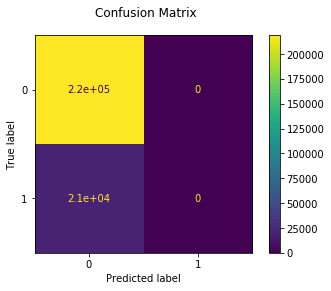

In [9]:
def printConfusion(clf):
    pred_y = clf.predict(test_x)

    acc = accuracy_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y)
    print(acc, f1)

    disp = plot_confusion_matrix(clf, test_x, test_y)
    disp.figure_.suptitle("Confusion Matrix")
    
printConfusion(clf)

In [4]:
# clf = LinearSVC(max_iter=3000)
# start = time.time()
# clf.fit(train_x, train_y)
# print(time.time()-start)

724.9685382843018


C:\Users\alanh\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9104872219770337 0.0


Text(0.5, 0.98, 'Confusion Matrix')

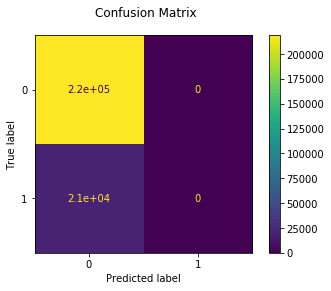

In [11]:
# printConfusion(clf)

In [ ]:
# clf = SVC()
# start = time.time()

# clf.fit(train_x, train_y)

# print(time.time()-start)

# printConfusion(clf)